<h2 style="color:blue" align="center">Wine Quality Prediction</h2>

#### Import the necessary libraries

In [215]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random as python_random
import time, math 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense 
from keras.callbacks import Callback, CSVLogger, EarlyStopping    

import warnings
warnings.filterwarnings('ignore')

#### Reserve GPU memory for the execution

In [216]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

#### Load the dataset

In [217]:
df = pd.read_csv('winequality-white.csv',sep=';')
df.shape

(4898, 12)

In [218]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [219]:
X = df.drop(['quality'],axis=1)
Y = df['quality']

#### Preprocess input

In [220]:
# Normalize the input dataset
scaler_MinMax = MinMaxScaler()
X = scaler_MinMax.fit_transform(X) 

#### Split the dataset into training and testing set

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0) 

In [222]:
X_train.shape

(3918, 11)

#### Define DNN model

In [223]:
python_random.seed(7)
np.random.seed(7)
tf.random.set_seed(7)
opti_name = ''

def get_model(): 
    tf.keras.backend.clear_session()
    model = Sequential([ 
        Dense(126, input_dim = 11, activation='relu'),  
        Dense(64, activation='relu'),   
        Dense(1)
    ], name = "DNN_model")
    
    global opti_name
    
    # General SGD
    #opti = keras.optimizers.SGD(learning_rate=0.001)
    #opti_name = 'SGD'
    
    # SGD with momentum
    #opti = keras.optimizers.SGD(learning_rate=0.001, momentum=0.4)
    #opti_name = 'SGD with momentum'
    
    # SGD with Nesterov momentum 
    #opti = keras.optimizers.SGD(learning_rate=0.001, momentum=0.4, nesterov=True)
    #opti_name = 'SGD with Nesterov momentum'
    
    # RMSprop 
    #opti = keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.4)
    #opti_name = 'RMSprop'
    
    # Adam
    opti = keras.optimizers.Adam(learning_rate=0.001) 
    opti_name = 'Adam'
    
    # Adamax
    #opti = keras.optimizers.Adamax(learning_rate=0.001) 
    #opti_name = 'Adamax'
    
    # Nadam
    #opti = keras.optimizers.Nadam(learning_rate=0.001) 
    #opti_name = 'Nadam'  

    
    model.compile(
        optimizer = opti,
        loss = 'mean_squared_error',
        metrics = ['mae']
    )
    
    return model

#### Custom callbacks

For generic optimizer model

In [224]:
# Get the best of base-line model and set it as stopping criteria in HM-based model
generic_best = 0

class CustomCallbackGeneric(Callback):  
    def on_epoch_end(self, epoch, logs={}): 
        global generic_best
        error = round(logs.get('mae'), 4) 
        
        if epoch == 0:
            generic_best = error     
        
        if epoch > 0 and error < generic_best :
            generic_best = error

For HM based optimizer model

In [225]:
class CustomCallbackHM(Callback):  
    initial_weights = 0
    previous_weights = 0
    call_hm = 0  
     
    def on_train_begin(self, logs=None):
        self.initial_weights = model_hm.get_weights() 
        self.initial_weights = np.array(self.initial_weights,dtype=object)
        self.previous_weights = self.initial_weights
        # Harmonic mean based weights calculation
        self.call_hm = np.vectorize(self.apply_hm)  
             
    def on_epoch_end(self, epoch, logs={}):  
        # Set the stopping criteria at (stop_at) the MAE obtained from the baseline model 
        global generic_best 
        
        num_layers = len(model_hm.layers)  
        current_weights = model_hm.get_weights()
        current_weights = np.array(current_weights,dtype=object)        

        for i in range(num_layers):  
            # Harmonic mean based weights calculation
            tensor1 = tf.convert_to_tensor(self.previous_weights[i])
            tensor2 = tf.convert_to_tensor(current_weights[i])
            current_weights[i] = self.call_hm(tensor1, tensor2, epoch)   
            
        # Updating the model with new weights
        model_hm.set_weights(current_weights.tolist())
        self.previous_weights = current_weights
        
        #Stopping criteria
        #if(round(logs.get('mae'), 4) < generic_best):  
            #self.model.stop_training = True
        
    def apply_hm(self, v1, v2, epoch):  
        r = 0
        if epoch < 100:
             r = 1
        elif epoch > 100 and epoch < 200:
             r = 0.85
        elif epoch > 200 and epoch < 300:
             r = 0.75
        else:  
             r = 0.65 
            
        if v1==0 or v2==0:
            return v2
        elif v1 > v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1)*r  
            v2 = v2 - diff
            return v2  
        elif v1 < v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1)*r
            v2 = v2 + diff
            return v2   
        else:
            return v2   

#### Training

Get a model to assign same weights to model with and without HM

In [226]:
model = get_model() 
weights = model.get_weights() 
num_epochs = 500
batch_size = 256

To record loss and accuracy in CSV file

In [227]:
generic_file = '7.Wine '+ opti_name +' optimizer.csv'
hm_file = '7.Wine '+ opti_name +' HM-based optimizer.csv' 
logger_generic_model = CSVLogger(generic_file, append = False, separator=',')
logger_hm_model = CSVLogger(hm_file, append = False, separator=',')

Generic opimizer model

In [228]:
model_wihtout_hm = get_model()
model_wihtout_hm.set_weights(weights) 
st = time.time() 
model_wihtout_hm.fit(X_train, y_train, epochs = num_epochs, verbose=0, callbacks=[CustomCallbackGeneric(), logger_generic_model], batch_size=batch_size) 
et = time.time()
elapsed_training_time_generic = round(et - st, 4)
print('Execution time:', elapsed_training_time_generic, 'seconds') 

Execution time: 7.738 seconds


HM based optimizer model

In [229]:
model_hm = get_model()
model_hm.set_weights(weights) 
st = time.time()
model_hm.fit(X_train, y_train, epochs = num_epochs, verbose=0, callbacks=[CustomCallbackHM(),logger_hm_model], batch_size=batch_size) 
et = time.time()
elapsed_training_time_hm = round(et - st, 4)
print('Execution time:', elapsed_training_time_hm, 'seconds') 

Execution time: 10.4071 seconds


Model summary

In [230]:
model_hm.summary()

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_312 (Dense)           (None, 126)               1512      
                                                                 
 dense_313 (Dense)           (None, 64)                8128      
                                                                 
 dense_314 (Dense)           (None, 1)                 65        
                                                                 
Total params: 9,705
Trainable params: 9,705
Non-trainable params: 0
_________________________________________________________________


#### Generic optimizer vs HM-based optimizer

In [231]:
df1 = pd.read_csv(generic_file)
df2 = pd.read_csv(hm_file)

Loss

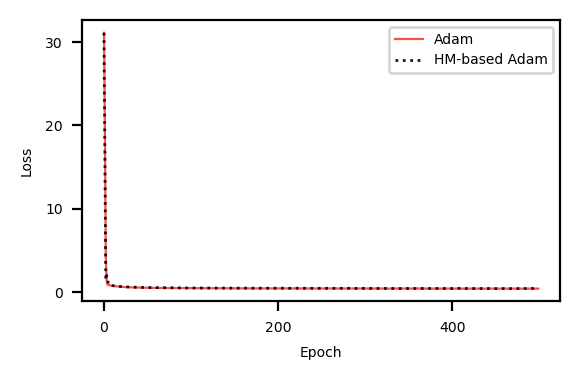

In [232]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['loss'] 
y2 = df2['loss']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Loss' , fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5}) 
#plt.yscale('log')
#plt.title("Loss", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()

MAE

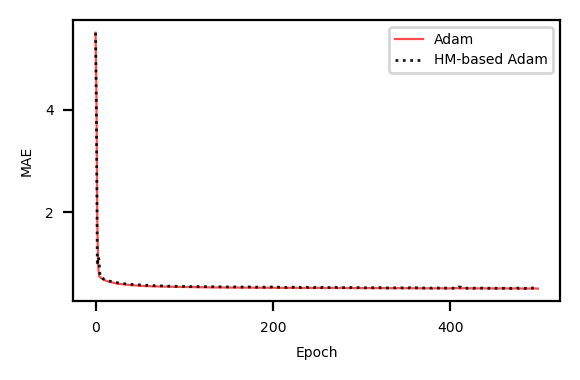

In [233]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['mae'] 
y2 = df2['mae']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('MAE' , fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5}) 
#plt.yscale('log')
#plt.title("MAE", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()

#### Testing the model

Generic opimizer model

In [234]:
generic_testing = model_wihtout_hm.evaluate(X_test, y_test)
generic_testing  

31/31 [==============================] - 0s 758us/step - loss: 0.5628 - mae: 0.5790


[0.5628064274787903, 0.5790373086929321]

HM based optimizer model

In [235]:
hm_testing = model_hm.evaluate(X_test, y_test)
hm_testing

31/31 [==============================] - 0s 659us/step - loss: 0.5984 - mae: 0.6067


[0.5983978509902954, 0.6067306399345398]

<h2 style="color:blue" align="center">Training Loss vs Validation Loss</h2>

For generic optimizer

In [236]:
model_wihtout_hm_val = get_model()
model_wihtout_hm_val.set_weights(weights) 
history = model_wihtout_hm_val.fit(X_train, y_train, epochs = num_epochs, verbose=0, validation_split=0.2, batch_size=batch_size) 

In [237]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

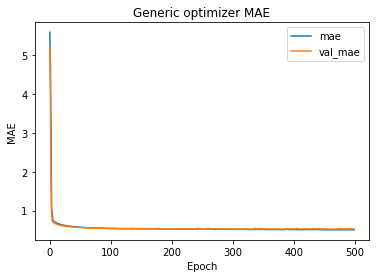

In [238]:
plt.figure(figsize=(6,4))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Generic optimizer MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['mae', 'val_mae'], loc='upper right')
plt.show()

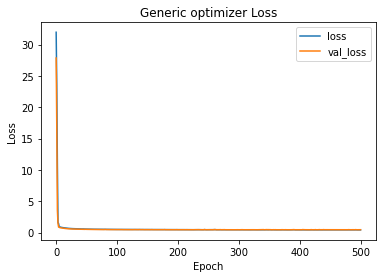

In [239]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Generic optimizer Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

For HM-based optimizer

In [240]:
model_wiht_hm_val = get_model()
model_wiht_hm_val.set_weights(weights) 
history_hm = model_wiht_hm_val.fit(X_train, y_train, epochs = num_epochs, verbose=0, validation_split=0.2, callbacks=[CustomCallbackHM()], batch_size=batch_size) 

In [241]:
history_hm.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

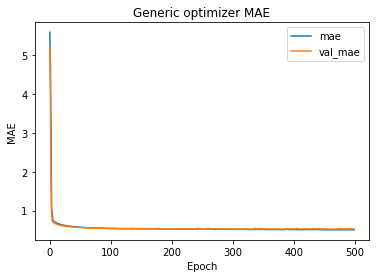

In [242]:
plt.figure(figsize=(6,4))
plt.plot(history_hm.history['mae'])
plt.plot(history_hm.history['val_mae'])
plt.title('Generic optimizer MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['mae', 'val_mae'], loc='upper right')
plt.show()

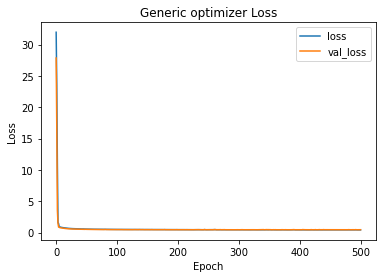

In [243]:
plt.figure(figsize=(6,4))
plt.plot(history_hm.history['loss'])
plt.plot(history_hm.history['val_loss'])
plt.title('Generic optimizer Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

<h2 style="color:blue" align="center">Cross Validation</h2>

In [244]:
num_folds = 5 
# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits = num_folds, shuffle = False)

# Define per-fold score containers  
mae_per_fold = []
loss_per_fold = []

mae_per_fold_hm = []
loss_per_fold_hm = [] 
 
# K-fold Cross Validation model evaluation
fold_no = 1

model = get_model() 
weights = model.get_weights() 

for train, test in kfold.split(inputs, targets):    
    model_wihtout_hm = get_model()
    model_wihtout_hm.set_weights(weights) 
    model_wihtout_hm.fit(inputs[train], targets[train], epochs = num_epochs, verbose = 0, batch_size = batch_size) 
    scores = model_wihtout_hm.evaluate(inputs[test], targets[test], verbose = 0)
    #print(f'Score for fold {fold_no}: {model_wihtout_hm.metrics_names[0]} of {scores[0]}; {model_wihtout_hm.metrics_names[1]} of {scores[1]}') 
    mae_per_fold.append(scores[1]) 
    loss_per_fold.append(scores[0])
    
    model_hm = get_model() 
    model_hm.set_weights(weights) 
    model_hm.fit(inputs[train], targets[train], epochs = num_epochs, verbose = 0, callbacks=[CustomCallbackHM()], batch_size = batch_size) 
    scores_hm = model_hm.evaluate(inputs[test], targets[test], verbose = 0)
    #print(f'Score for fold {fold_no}: {model_hm.metrics_names[0]} of {scores_hm[0]}; {model_hm.metrics_names[1]} of {scores_hm[1]}') 
    mae_per_fold_hm.append(scores_hm[1]) 
    loss_per_fold_hm.append(scores_hm[0])
    
    fold_no = fold_no + 1 

In [245]:
# == Provide average scores ==
print('-------------------------------------------')
print('Score per fold for model without HM')
for i in range(0, num_folds):
  print('-------------------------------------------')
  print(f'> Fold {i+1} - Loss: {round(loss_per_fold[i],3)} - MAE: {round(mae_per_fold[i],3)}')
print('-------------------------------------------')
print('Average scores for all folds:')
print(f'> MAE: {round(np.mean(mae_per_fold),3)} (+- {round(np.std(mae_per_fold),3)})')
print(f'> Loss: {round(np.mean(loss_per_fold),3)}')
print('-------------------------------------------')
print('Score per fold for model with HM')
for i in range(0, num_folds):
  print('-------------------------------------------')
  print(f'> Fold {i+1} - Loss: {round(loss_per_fold_hm[i],3)} - MAE: {round(mae_per_fold_hm[i],3)}')
print('-------------------------------------------')
print('Average scores for all folds:')
print(f'> MAE: {round(np.mean(mae_per_fold_hm),3)} (+- {round(np.std(mae_per_fold_hm),3)})')
print(f'> Loss: {round(np.mean(loss_per_fold_hm),3)}')
print('-------------------------------------------')

-------------------------------------------
Score per fold for model without HM
-------------------------------------------
> Fold 1 - Loss: 0.47 - MAE: 0.536
-------------------------------------------
> Fold 2 - Loss: 0.458 - MAE: 0.531
-------------------------------------------
> Fold 3 - Loss: 0.511 - MAE: 0.55
-------------------------------------------
> Fold 4 - Loss: 0.453 - MAE: 0.521
-------------------------------------------
> Fold 5 - Loss: 0.591 - MAE: 0.588
-------------------------------------------
Average scores for all folds:
> MAE: 0.545 (+- 0.023)
> Loss: 0.497
-------------------------------------------
Score per fold for model with HM
-------------------------------------------
> Fold 1 - Loss: 0.444 - MAE: 0.521
-------------------------------------------
> Fold 2 - Loss: 0.466 - MAE: 0.536
-------------------------------------------
> Fold 3 - Loss: 0.501 - MAE: 0.542
-------------------------------------------
> Fold 4 - Loss: 0.469 - MAE: 0.534
-------------

#### Release the GPU memory